# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
# Downloading the JSRT dataset.
!rm -r ./*
!mkdir jsrt
!wget https://www.dropbox.com/sh/grjpx4oeacg32c0/AAAPpBgABESAWz-se4eCP9-Ya -O jsrt.zip
!unzip -q jsrt.zip -d jsrt
!ls jsrt

--2019-07-16 04:25:39--  https://www.dropbox.com/sh/grjpx4oeacg32c0/AAAPpBgABESAWz-se4eCP9-Ya
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/grjpx4oeacg32c0/AAAPpBgABESAWz-se4eCP9-Ya [following]
--2019-07-16 04:25:39--  https://www.dropbox.com/sh/raw/grjpx4oeacg32c0/AAAPpBgABESAWz-se4eCP9-Ya
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89ba3e4f81aaa06b4b30618b51.dl.dropboxusercontent.com/zip_by_token_key?key=AkyJa7PUw193PT7NAQdkdbRgQqPKQ93O324mAh6uIq7Xbp-DVlWZXkE0LN6CIfvyZAK3-JIetPilhPQUHNtqTI01zjCoQuRQEMnn3OkDhVnMFdc_Ba7oC_avbRpZCf1SO92XI-pBzTowTXpvndx7SX05ufUYLYLQBilCszKLBKXGP_wK2cRHNa7R9xQI848D0yu3nK_BKpy6oHKr2fuZVOc1 [following]
--2019-07-16 04:25:40--  https://uc89ba3e4f81aaa06b4b30618b51.dl.dropboxuserconte

In [0]:
# Basic imports.
import os
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from skimage import io
from skimage import transform

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'dataset': 'jsrt',    # Dataset.
    'task': 'lungs',      # Task.
    'n_classes': 2,       # Number of classes in segmentation task.
    'network': 'unet',    # Network architecture.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 8,      # Mini-batch size.
    'w_size': 256,        # Width size for image resizing.
    'h_size': 256,        # Height size for image resizing.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [0]:
# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [0]:
def evaluate(prds, labs, num_classes):
    
    iou_list = []
    f1_list = []
    
    for prd, lab in zip(prds, labs):
        
        iou = metrics.jaccard_score(lab.ravel(), prd.ravel())
        f1 = metrics.f1_score(lab.ravel(), prd.ravel())
        
        iou_list.append(iou)
        f1_list.append(f1)
        
    iou_list = np.asarray(iou_list)
    f1_list = np.asarray(f1_list)
    
    return iou_list, f1_list

# Dataloaders Customizados

Os frameworks de Deep Learning modernos (i.e. MXNet e Pytorch) permitem a criação de dataloaders customizados ao se sobrescreverem classes desses frameworks. Esse tipo de dataloader é especialmente útil no caso de tarefas diferentes das de classificação que temos visto até agora (i.e. segmentação e detecção de imagens, processamento de áudio, processamento de linguagem, natural, etc), nas quais os labels podem ser mais esparsos ou densos que rótulos de classificação.

Usando como base as classes [*Dataloader*](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) e [*Dataset*](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) do subpacote [*data*](https://pytorch.org/docs/stable/data.html) do Pytorch, podemos customizar a leitura dos dados ao mesmo tempo em que paralelizamos a leitura das amostras dos nossos batches. A paralelização da leitura de amostras em várias [threads](https://www.tutorialspoint.com/python/python_multithreading) torna o uso da GPU o mais eficiente possível, já que não é necessário deixar a GPU esperando pelo carregamento de novas amostras para compor um batch.

In [0]:
# Class that reads a sequence of image paths from a text file and creates a data.Dataset with them.
class ListDataset(data.Dataset):

    def __init__(self, root, mode, dataset, task, resize_to=(256, 256), in_channels=1, num_classes=2):

        # Initializing variables.
        self.root = root
        self.mode = mode
        self.dataset = dataset
        self.task = task
        self.resize_to = resize_to
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Creating list of image files.
        self.imgs = self.make_dataset()
        
        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set'))

    def make_dataset(self):

        # Making sure the mode is correct.
        assert self.mode in ['train', 'test']

        # Joining input paths.
        self.img_path = os.path.join(self.root,
                                     self.dataset,
                                     'images')
        self.msk_path = os.path.join(self.root,
                                     self.dataset,
                                     'ground_truths',
                                     self.task)

        # Reading paths from file.
        items = [l.strip('\n') for l in open(os.path.join(self.root,
                                                          self.dataset,
                                                          self.task + '_' + self.mode + '.txt')).readlines()]

        # Returning list.
        return items
    
    def __getitem__(self, index):

        # Reading items from list and mounting .
        f = self.imgs[index]
        
        img_path = os.path.join(self.img_path, f)
        msk_path = os.path.join(self.msk_path, f)
        
        # Reading images.
        img = io.imread(img_path)
        msk = io.imread(msk_path)

        # Resising images.
        img = transform.resize(img, self.resize_to,
                               preserve_range=True, order=1)
        msk = transform.resize(msk, self.resize_to,
                               preserve_range=True, order=0)

        # Casting images to the appropriate dtypes.
        img = img.astype(np.float32)
        msk = msk.astype(np.int64)
        
        if self.num_classes == 2:
            msk[msk > 0] = 1

        # Normalization (z-score).
        if self.in_channels == 1:
            img = (img - img.mean()) / img.std()
        else:
            for i in range(img.shape[2]):
                img[:,:,i] = (img[:,:,i] - img[:,:,i].mean()) / img[:,:,i].std()

        # Fixing channel dimension.
        if self.in_channels == 1:

            # If number of input channels is 1, simply add a new dimension.
            img = np.expand_dims(img, axis=0) # From (H, W) to (C=1, H, W).
            
        else:
            
            # Else, transpose array.
            img = np.transpose(img, (2, 0, 1)) # From (H, W, C) to (C, H, W).

        # Turning numpy arrays to tensors.
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        # Returning to iterator.
        return img, msk

    def __len__(self):

        return len(self.imgs)

# Instantiating dataloaders.
root = './'

# Setting datasets.
train_set = ListDataset(root,
                        'train',
                        args['dataset'],
                        args['task'],
                        (args['h_size'], args['w_size']))
test_set = ListDataset(root,
                       'test',
                       args['dataset'],
                       args['task'],
                       (args['h_size'], args['w_size']))

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         num_workers=args['num_workers'],
                         shuffle=False)

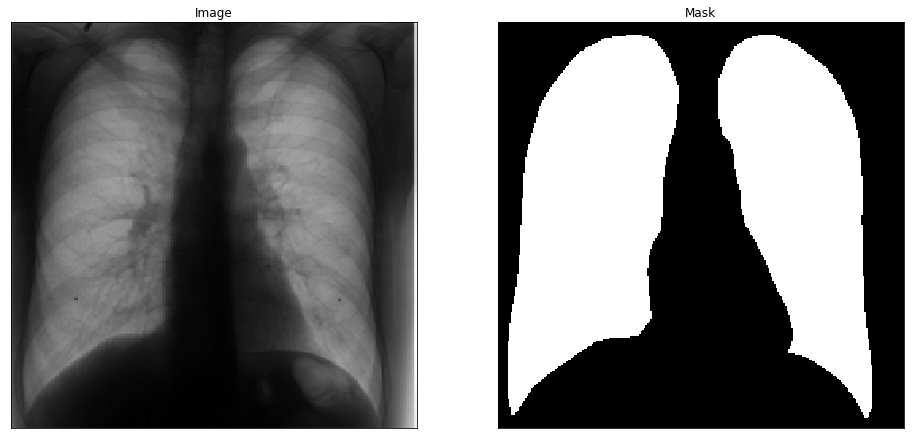

In [0]:
for i, batch_data in enumerate(train_loader):
    
    img, lab = batch_data
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].imshow(img[0, 0].numpy(), cmap=plt.get_cmap('gray'))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title('Image')
    
    ax[1].imshow(lab[0].numpy(), cmap=plt.get_cmap('gray'))
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title('Mask')
    
    plt.show()
    
    break

# Arquiteturas Encoder-Decoder

FCNs foram as primeiras redes neurais profundas para Segmentação Semântica, porém o uso de interpolações bilineares para alimentar as camadas convolucionais finais da rede pode tornar a segmentação pouco sensível a detalhes pequenos nas imagens de entrada, mesmo com o uso de **Skip Connections**. Entre 2015 e 2017 foram propostas as primeiras arquiteturas **Encoder-Decoder** para Segmentação Semântica que, ao invés de realizarem interpolações para recuperar a resolução espacial dos feature maps, usam **Convoluções Transpostas** com filtros treináveis. Isso torna o processo de upsampling dos feature maps de baixa resolução mais fidedigno a detalhes nas imagens de entrada.

![**Convolução**](http://deeplearning.net/software/theano_versions/dev/_images/no_padding_no_strides.gif)![**Convolução Transposta**](http://deeplearning.net/software/theano_versions/dev/_images/no_padding_no_strides_transposed.gif)

As regiões com os feature maps de menor resolução espacial em arquiteturas Encoder-Decoder são chamadas de bottlenecks dessas redes e as camadas de **Convolução** e **Convolução Transposta** dos dois lados do bottleneck de uma rede são muito frequentemente simétricas, como pode ser visto na imagem abaixo.

![Encoder-Decoder](https://www.dropbox.com/s/kd40qyqmusweovu/Unet.png?dl=1)

Duas arquiteturas Encoder-Decoder para segmentação se destacam na literatural atual: as [**U-Nets**](https://arxiv.org/pdf/1505.04597.pdf) e as [**SegNets**](https://arxiv.org/pdf/1511.00561.pdf), possuindo desempenho similar na maioria das aplicações. U-Nets seguem a filosofia da [**VGG**](https://arxiv.org/abs/1409.1556) com convoluções 3x3 e padding de tamanho 1 com a resolução espacial dos feature maps sendo controlada por Max Poolings entre os blocos convolucionais. As camadas do Decoder das U-Nets recebem os feature maps computados pelas suas camadas simétricas no Encoder concatenados à saída da camada anterior. Essa operação é análoga às Skip Connections das FCNs, porém feitas para cada par de camadas simétricas (ou seja, que geram filtros com as mesmas resoluções espaciais). Isso faz com que os decoders das U-Nets possuam consideravelmente mais filtros que os Encoders, como também pode ser visto no esquema abaixo.

![U-Nets](https://www.dropbox.com/s/woistektygmv693/unets.png?dl=1)

Assim como nas FCNs, as U-Nets implementam os Skip Connections com concanteções no eixo dos canais, como mostrado na imagem a seguir.

![Skip U-Nets](https://www.dropbox.com/s/ao9878yf2ke5ce1/Nets_UNet_Petro.png?dl=1)

Enquanto U-Nets concatenam os feature maps de saída das camadas do Encoder como inputs para as camadas do Decoder, as SegNets se aproveitam dos índices das operações de Max Pooling 2D do Encoder para computar o Decoder. A diferença mais marcante entre as U-Nets e as SegNets se dá na forma como as resoluções de entrada são restauradas após o bottleneck, ou seja, no Decoder.

![SegNets](https://www.dropbox.com/s/4605yaowoxuqbfu/segnets.png?dl=1)

Os índices dos Max Poolings das camadas do Encoder são utilizados para gerar feature maps esparsos no Decoder, os quais são passados para **Convoluções Transpostas** para realizar o upsampling.

![Max Pooling Indices](https://www.dropbox.com/s/ub8y5t27u1ucdwd/pool_indices.png?dl=1)

# Atividade Prática: Implementando U-Net

1.   Implementar as classes *EncoderBlock* e *DecoderBlock*. Ambas *\_\_init\_\_()* e *forward()* devem ser complementadas para as classes.
2.   Usar as classes *EncoderBlock* e *DecoderBlock* na classe *U-Net*.
3.   Instanciar um otimizador e uma loss.
4.   Complementar trechos TO DO nas funções *train()* e *test()*.

PS.: Todas as convoluções de uma U-Net são 3x3 com padding igual a 1, menos a última que tem kernel 1x1 para realizar a predição densa para cada pixels de acordo com o número de classes.

In [0]:
class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(EncoderBlock, self).__init__()

        # TO DO: each encoder block be composed of:
        #        1) 2d conv inputting in_channels and outputting out_channels;
        #        2) batch norm;
        #        3) ReLU;
        #        4) 2d conv outputting out_channels;
        #        5) batch norm;
        #        6) ReLU;
        #        7) max pooling 2d with kernel 2x2 and stride of 2.
        self.encode = # ...

    def forward(self, x):

        # TO DO: implement forward on self.encode.
        return # ...


class DecoderBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels):

        super(DecoderBlock, self).__init__()

        # TO DO: each decoder block be composed of:
        #        1) channel dropout;
        #        2) 2d conv inputting in_channels and outputting
        #           middle_channels;
        #        3) batch norm;
        #        4) 2d conv outputting middle_channels;
        #        5) batch norm;
        #        6) ReLU;
        #        7) transposed 2d conv outputting out_channels with kernel 2x2,
        #           stride of 2, padding and output_padding of 0.
        self.decode = # ...

    def forward(self, x):

        # TO DO: implement forward on self.decode.
        return # ...


class UNet(nn.Module):

    def __init__(self, input_channels, num_classes):

        super(UNet, self).__init__()

        # TO DO: this U-Net will be composed of 4 Encoder Blocks and 4
        #        Decoder Blocks:
        #        1) Encoder Block inputting input_channels and outputting 64
        #           channels;
        #        2) Encoder Block outputting 128 channels;
        #        3) Encoder Block 256 channels;
        #        4) Encoder Block outputting 512 channels;
        #        5) Decoder Block inputting 512 channels, 1024 middle channels
        #           and outputting 512 channels;
        #        6) Decoder Block inputting 1024 channels, 512 middle channels
        #           and outputting 256 channels;
        #        7) Decoder Block inputting 512 channels, 256 middle channels
        #           and outputting 128 channels;
        #        8) Decoder Block inputting 256 channels, 128 middle channels
        #           and outputting 64 channels;
        #        9) 2d conv block (conv + batch norm + ReLU) outputting 64
        #           channels;
        #        10) 2d conv block (conv + batch norm + ReLU) outputting 64
        #            channels;
        #        11) 2d conv block with kernel 1x1 outputting num_classes
        #            channels. This is the pixel classification layer.
        
        self.enc1 = # Encoder Block...
        self.enc2 = # Encoder Block...
        self.enc3 = # Encoder Block...
        self.enc4 = # Encoder Block...
        
        self.center = # Decoder Block...
        self.dec4 = # Decoder Block...
        self.dec3 = # Decoder Block...
        self.dec2 = # Decoder Block...

        self.dec1 = # Channel dropout + 2 conv blocks.

        self.final = # 1x1 conv outputting num_classes channels.

        # Random initialization for weights.
        initialize_weights(self)

    def forward(self, x):

        # TO DO: implement forward on Encoder Blocks.
        enc1_out = # ...
        enc2_out = # ...
        enc3_out = # ...
        enc4_out = # ...

        # TO DO: implement forward on Decoder Blocks. Each Decoder receives the
        #        output of the last layer concatenated with the output of an
        #        Encoder Block with compatible size. See U-Net architectural
        #        scheme above.
        center_out = # ...
        dec4_out = # ...
        dec3_out = # ...
        dec2_out = # ...
        
        # TO DO: implement forward on the final 2 conv blocks and final 1x1
        #        conv to predict classes.
        dec1_out = # ...

        final_out = # ...

        # TO DO: return output.
        return # ...


net = UNet(1, num_classes=args['n_classes']).to(args['device'])

print(net)

In [0]:
# TO DO: Setting optimizer.
optimizer = # ...

In [0]:
# TO DO: Setting loss.
criterion = # ...

In [0]:
# Training function.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Average Meter for batch loss.
    train_loss = []

    # Lists for whole epoch loss.
    labs_all, prds_all = [], []

    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables (inps and labs).

        # TO DO: Clearing the gradients of optimizer.

        # TO DO: Forwarding.
        outs = # ...

        # TO DO: Computing loss.
        loss = # ...

        # TO DO: Computing backpropagation and taking optimizer step.
        
        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()

        # Appending images for epoch loss calculation.
        labs_all.append(labs.detach().data.squeeze(0).cpu().numpy())
        prds_all.append(prds)

        # Updating loss meter.
        train_loss.append(loss.data.item())

    toc = time.time()
    
    # Transforming list into numpy array.
    train_loss = np.asarray(train_loss)
    
    # Computing error metrics for whole epoch.
    iou, f1 = evaluate(prds_all, labs_all, args['n_classes'])

    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), iou.mean(), iou.std(), f1.mean(), f1.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Average Meter for batch loss.
    test_loss = []

    # Lists for whole epoch loss.
    labs_all, prds_all = [], []

    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables.
        
        # TO DO: Forwarding.
        outs = # ...

        # TO DO: Computing loss.
        loss = # ...

        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()

        # Appending images for epoch loss calculation.
        labs_all.append(labs.detach().data.squeeze(0).cpu().numpy())
        prds_all.append(prds)

        # Updating loss meter.
        test_loss.append(loss.data.item())
    
    toc = time.time()
    
    # Transforming list into numpy array.
    test_loss = np.asarray(test_loss)
    
    # Computing error metrics for whole epoch.
    iou, f1 = evaluate(prds_all, labs_all, args['n_classes'])

    # Printing test epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), iou.mean(), iou.std(), f1.mean(), f1.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


-------------------------------------------------------------------
[epoch 1], [train loss 0.5387 +/- 0.1069], [iou 0.5030 +/- 0.1272], [f1 0.6586 +/- 0.1282], [time 64.00]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 1], [test loss 0.4025 +/- 0.0505], [iou 0.6095 +/- 0.0782], [f1 0.7543 +/- 0.0626], [time 12.48]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.3321 +/- 0.0523], [iou 0.6867 +/- 0.0550], [f1 0.8130 +/- 0.0387], [time 25.72]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [test loss 0.3863 +/- 0.1087], [iou 0.6638 +/- 0.0832], [f1 0.7948 +/- 0.0631], [time 3.84]
-------------------------------------------------------------------
---------------------------------------